![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr Ćwiakowski

### Lekcja 2. Modele typu white-box

#### Spis treści:

1. Wprowadzenie
2. Drzewa decyzyjne
3. General Additive Model (GAM)¶

# 1 Wprowadzenie

Czasami, kiedy jednoznaczne wyjaśnienie mechanizmu generowania prognoz jest kluczowe, nie możemy korzystać ze złożonych modeli uczenia maszynowego. Musimy wtedy skorzystać z tzw. modeli transparentnych, jak:

- modele liniowe (OLS, logit, etc.),
- drzewa decyzyjne,
- General Additive models. 

Modele liniowe są absolutnie podstawowym narzędziem, więc omówimy jedynie dwie pozostałe techniki. Przygotujmy dane i pakiety do dalszej analizy.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Arial"
sns.set(style='whitegrid')
sns.set_palette("bright")

%matplotlib inline

import pydotplus
from six import StringIO 
from IPython.display import Image  
from svglib.svglib import svg2rlg # pip install svglib
from sklearn.tree import export_graphviz 

# Machine learing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.datasets import load_diabetes

# Modele
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from pygam import LinearGAM, s, te, f, LogisticGAM

In [2]:
df = pd.read_csv("data/bank-balanced.csv")
print(df.shape)

target = "deposit"
numFeatures = ['age', 'balance', 'duration', 'campaign', 'pdays','previous', 'day']
catFeatures = [ 'job', 'marital', 'education', 'default',  'housing', 'loan', 'contact',  'month', 'poutcome']

df[target] = (df[target]=="yes").astype(int)

mapy = {}
for feature in catFeatures:
    # Iniciujemy obiekt do kodowania, który będzie przechowywał naszą mapę
    le = LabelEncoder()
    # Dopasowujemy danę (tworzymy mapę) i od razu ją nakadamy na zmienną na której robiliśmy dopasowanie
    df[feature] = le.fit_transform(df[feature])

    # Zapiszmy nasza mapę, aby móc odzyskać oryginalne dane bez problemu
    mapy[feature] = le
    
features = df.columns.tolist()
features.remove(target)
print(features)

df.head()

(11162, 17)
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


Wykonajmy macierz korelacji między zmiennymi:

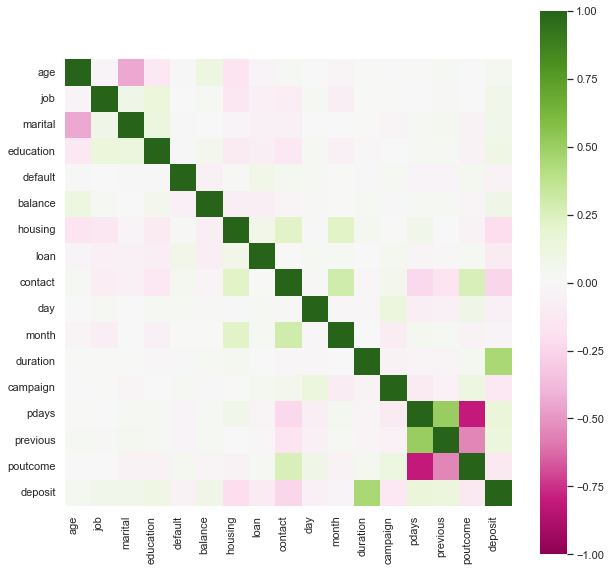

In [3]:
corr = df.corr()

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap="PiYG", square=True, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right');

In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(df, df['deposit'], test_size=0.2, random_state=42, stratify=df['deposit'])

# 2 Drzewa decyzyjne

Drzewa decyzyjne są podstawą wielu modeli złożonych (lasy losowe, boosting). Model był omawiany na kursie podstawowym, więc poprzestaniemy jedynie na przedstawieniu przykładu aplikacyjnego.

In [5]:
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt_depth3 = DecisionTreeClassifier(max_depth=3, random_state=42)

In [6]:
dt = dt.fit(X_tr[features], y_tr)
dt_depth3 = dt_depth3.fit(X_tr[features], y_tr)

In [7]:
pred_dt_tr = dt.predict_proba(X_tr[features])[:,1]
pred_d3_tr = dt_depth3.predict_proba(X_tr[features])[:,1]
pred_dt_te = dt.predict_proba(X_te[features])[:,1]
pred_d3_te = dt_depth3.predict_proba(X_te[features])[:,1]

In [8]:
roc_auc_score(y_tr, pred_dt_tr), roc_auc_score(y_te, pred_dt_te)

(1.0, 0.7805799782809798)

In [9]:
roc_auc_score(y_tr, pred_d3_tr), roc_auc_score(y_te, pred_d3_te)

(0.8290541170760244, 0.835413264690504)

In [10]:
print(features)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


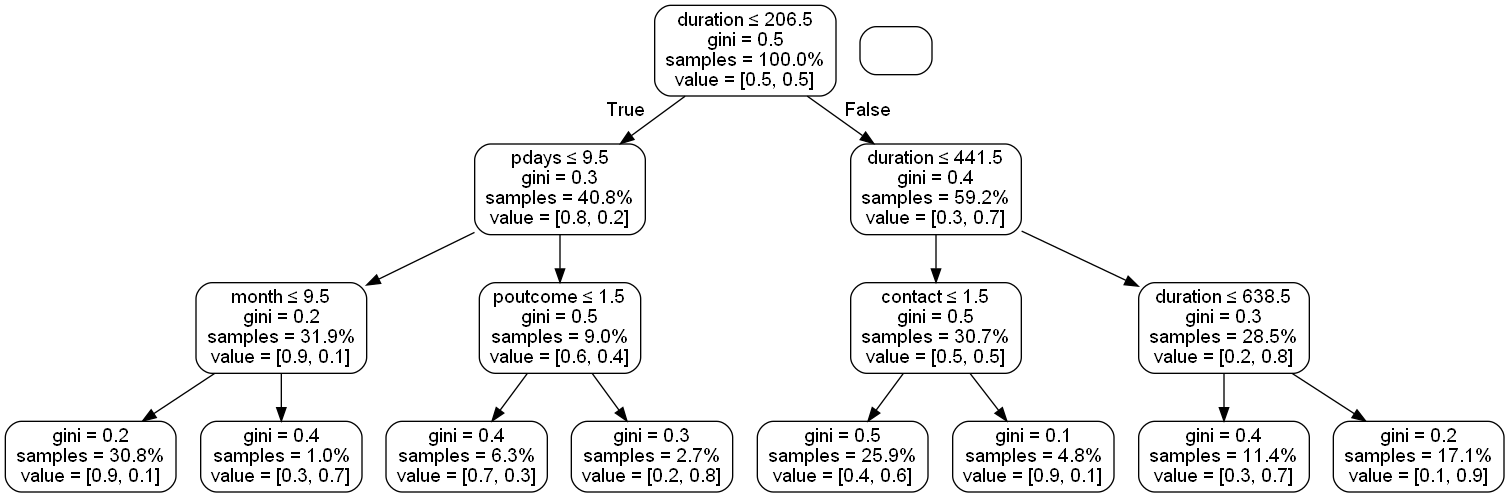

In [11]:
# UWAGA! Jeśli procedura mimo instalacji pakietu nie będzie działała, trzeba wejści na stronę: https://graphviz.org/download/ 
# i zainstalować odpowiednią wersję poprzez plik .exe (np. graphviz-4.0.0 (64-bit) EXE installer [sha256]s)

bank_dt_dot_data = StringIO()
export_graphviz(dt_depth3, out_file=bank_dt_dot_data,
                filled=False, rounded=True,
                feature_names=features,
                proportion=True, precision=1,
                special_characters=True)

dt_graph = pydotplus.graph_from_dot_data(bank_dt_dot_data.getvalue())  

Image(dt_graph.create_png())

In [12]:
bank_dt_dot_data = StringIO()
export_graphviz(dt, out_file=bank_dt_dot_data,
                filled=False, rounded=True,
                feature_names=features,
                proportion=True, precision=1,
                special_characters=True)

dt_graph = pydotplus.graph_from_dot_data(bank_dt_dot_data.getvalue())  

Image(dt_graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.461923 to fit



Text(0, 0.5, 'Features')

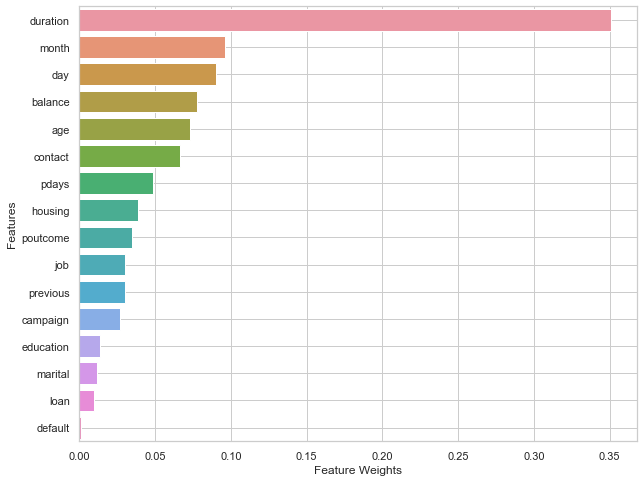

In [13]:
weights = dt.feature_importances_
sort = np.argsort(weights)[::-1]

feature_imp = [features[idx] for idx in sort]
feature_imp_val = [weights[idx] for idx in sort]

f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_imp_val, y=feature_imp, ax=ax)
ax.grid(True)
ax.set_xlabel('Feature Weights')
ax.set_ylabel('Features')

Tuning w `sklearn`:

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

clf = DecisionTreeClassifier(random_state=42)
grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=3).fit(X_tr[features], y_tr)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", roc_auc_score(y_tr, grid_cv.predict(X_tr[features])))
print("Test AUC ROC Score for GS: ", roc_auc_score(y_te, grid_cv.predict(X_te[features])))

Param for GS {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
CV score for GS 0.8656664058777989
Train AUC ROC Score for GS:  0.8169020011734025
Test AUC ROC Score for GS:  0.8101978844065478


In [ ]:
# Post pruning:
# https://towardsdatascience.com/3-techniques-to-avoid-overfitting-of-decision-trees-1e7d3d985a09
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

### underfitting v. overfitting

In [14]:
np.random.seed(42)
n_samples = 100

X = np.linspace(0, 10, 100)
rng = np.random.randn(n_samples) * 100

y = 2 * X**0.5 + X ** 3 + rng + 100

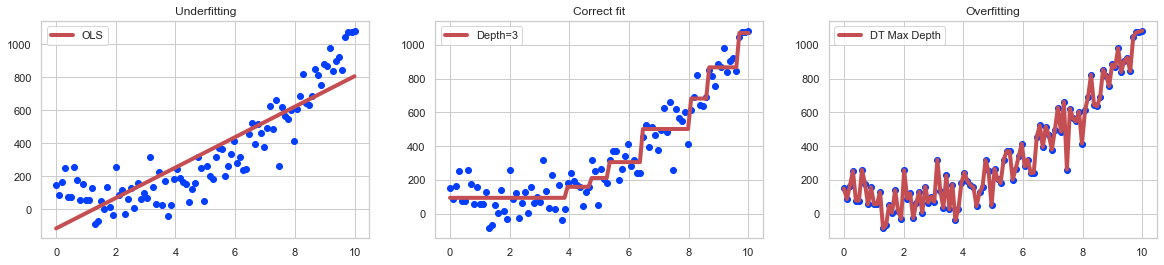

In [15]:
f, ax = plt.subplots(ncols=3, figsize=(20, 4))

lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)
model_pred = lr.predict(X.reshape(-1,1))


# Underfitting
ax[0].scatter(X, y)
ax[0].plot(X, model_pred, 'r-', label='OLS', linewidth=4);
ax[0].set_title('Underfitting')
ax[0].legend()

dt = DecisionTreeRegressor(random_state=42, max_depth=3)
dt.fit(X.reshape(-1, 1), y)
model_pred = dt.predict(X.reshape(-1,1))

ax[1].scatter(X, y)
ax[1].plot(X, model_pred, 'r-', label='Depth=3', linewidth=4);
ax[1].set_title('Correct fit')
ax[1].legend()

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X.reshape(-1, 1), y)
model_pred = dt.predict(X.reshape(-1,1))

ax[2].scatter(X, y)
ax[2].plot(X, model_pred, 'r-', label='DT Max Depth', linewidth=4);
ax[2].set_title('Overfitting')
ax[2].legend()

# 3 General Additive Model (GAM)

## 3.1 Wprowadzenie

Modele klasy GAM umożliwiają szacowanie nieliniowych zależności w modelach addytywnych. Dzięki temu:
* są relatywnie łatwe w interpretacji,
* bardzo elastyczna forma funkcyjna umożliwia znajdowanie w danych nieoczywistych i nieliniowych zależności,

Ponadto:
* model ma wbudowaną regularyzację, przez co unikamy przetrenowania modelu,
* w GAM można wykorzystywać nieliniowe link function – jak w GLM - dlatego za pomocą GAM można rozwiązywać za równo problemy regresyjne jak klasyfikacyjne.

Mimo oczywistych zalet, modele GAM nie są jednak popularnymi technikami w biznesie – wybór postaci funkcyjnej, mimo pewnej automatyzacji wymaga ręcznej specyfikacji, pracy teoretycznej (potencjalne interakcje między zmiennymi) oraz pomysłu. Jeśli mamy do czynienia z 100+ lub nawet 20+ zmiennymi, proces wymaga od nas zbyt wiele czasu, stąd częściej stosowane SVM, Random Forest czy boostowane drzewa. GAM może okazać się dobrym pomysłem dla zbiorów danych małych pod względem liczby obserwacji (poniżej 2-5K obserwacji) oraz kolumn (przykładowo mniej niz 10). Ponadto zmienne powinny być ciągłe, żeby można było skorzystać z atutów modelu.  

W podejściu stosowanym przez GAM szacuje się następujący model:

$$𝑔(𝐸(𝑦))=β+𝑓_1 (𝑥_1)+𝑓_2 (𝑥_2)+…+𝑓_𝑘 (𝑥_𝑘)$$

gdzie:
g(.) – funkcja link, pozwalają przekształcić zależność między Y a X na liniową (additive predictor),   
𝑓_𝑖 (.) - gładkie, nieparametryczne transformacje zmiennej 𝑥_𝑖,

Przykładowy wynik może być następujący:

<img src="img/gam1.png" width="50%">
Źródło: http://multithreaded.stitchfix.com/blog/2015/07/30/gam/

## 3.2 Zrozumieć GAM

Po zapoznaniu się z ideą modelu, można przejść do odpowiedzi na pytamie jak w istocie znajdowane są te gładkie, nieliniowe transformacje zmiennych. Punktem wyjścia są oczywiście wielomiany. Okazuje się, że całkiem nieźle mogą przybliżać wiele nieliniowych trendów, spójrzmy na rysunek:

<img src="img/gam2.png" width="40%">
Źródło: Thampi, Ajay. Interpretable AI: Building explainable machine learning systems. Simon and Schuster, 2022. 

Wielomiany mają jednak swoje wady - stopień kazdego wielomianu trzeba ustalać samodzielnie (co przy dużej liczbie zmiennych i mocno nieregularnych efektach może być uciążliwe), a poza tym ma tendencje (zgodnie z literaturą) to przetrenowywania się. Dlatego w GAM korzysta się z bardziej złożonych funkcji wygładzających (z ang. *smoothing functions*). Najpopularniejszą odmianą są tzw. *regression splines* i właśnie one są zaimplementowane w GAM. Według tego podejścia $f_j$ można zapisać jako:

<img src="img/gam3.png" width="20%">
Źródło: Thampi, Ajay. Interpretable AI: Building explainable machine learning systems. Simon and Schuster, 2022. 

Zmienną $x_j$ dzieli się na K przedziałów, z których każdy jest modelowany przez osobną funkcje bazową $b_k$, która jest tzw. spline'em, czyli wielomianem n-tego stopnia. Do odzwierciedlenia większości kształtów zazwyczaj wystarczy wielomian 3-ciego stopnia. Dlatego spline'y tego typu nazywamy *cubic splines*. Algorytm musi nauczyć się wagi dla każdej funkcji bazowej (w ten sposób manipuluje kształtem - w celu zmiany linii trendu wygasza niektóre wielomiany). Liczba przedziałów (zwana również liczbą stopni swobody) - K - ustalana jest "automatycznie" przez model i nie musimy się nią przejmować. Poniżej zilustrowano dwa rozwiązania - dla równych i nierównych wag:

<img src="img/gam4.png" width="60%">
Źródło: Thampi, Ajay. Interpretable AI: Building explainable machine learning systems. Simon and Schuster, 2022. 

Ponieważ GAM bardzo łatwo się przetrenowuje, potrzebny jest komponent regularyzacyjny $\lambda$ używany analogicznie jak w L1/L2: 

<img src="img/gam5.png" width="20%">

Na rysunku poniżej zilustrowano wpływ parametru $\lambda$ na gibkość dopasowanego modelu:

<img src="img/gam6.png" width="50%">
Źródło: https://multithreaded.stitchfix.com/blog/2015/07/30/gam/

## 3.3 Przykład aplikacyjny ( z książki *Interpretable AI:  Building explainable machine learning systems*)

In [3]:
# Wczytanie i przygotowanie danych
diabetes = load_diabetes()
X, y = diabetes['data'], diabetes['target'] 
# Target: Column 11 is a quantitative measure of disease progression one year after baseline
# Dokumentacja zbioru:
print(diabetes['DESCR'])

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lista zmiennych objasniających
feature_names = ['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
# Definiowanie modelu
gam = LinearGAM(s(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), n_splines=35) # n_splines - max. K dla funkcji wygładzającej

# Z ksiązki Inrepretable AI:
# Uses grid search to perform training and crossvalidation
# to determine the number of splines, the
# regularization parameter lambda, and the optimum
# weights for the regression splines for each feature

gam.gridsearch(X_train, y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + intercept,
   tol=0.0001, verbose=False)

In [26]:
# Podsumowanie
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     27.7114
Link Function:                     IdentityLink Log Likelihood:                                  -3142.722
Number of Samples:                          353 AIC:                                             6342.8668
                                                AICc:                                            6348.1441
                                                GCV:                                             3411.4587
                                                Scale:                                            2933.054
                                                Pseudo R-Squared:                                   0.5552
Feature Function                  Lam

C:\Users\pcwia\AppData\Local\Temp\ipykernel_3508\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [5]:
# Błędy dopasowania (można z ciekawości porównać z tradycyjnym modelem)
y_pred = gam.predict(X_test)

mae = np.mean(np.abs(y_test - y_pred))
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs(y_test - y_pred) / y_test) * 100
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

MAE: 41.383326521833155
RMSE: 52.229910552735696
MAPE: 35.674305762856804


Porównanie GAM z innymi modelami:

<img src="img/gam7.png" width="40%">
Źródło: Thampi, Ajay. Interpretable AI: Building explainable machine learning systems. Simon and Schuster, 2022.

['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']


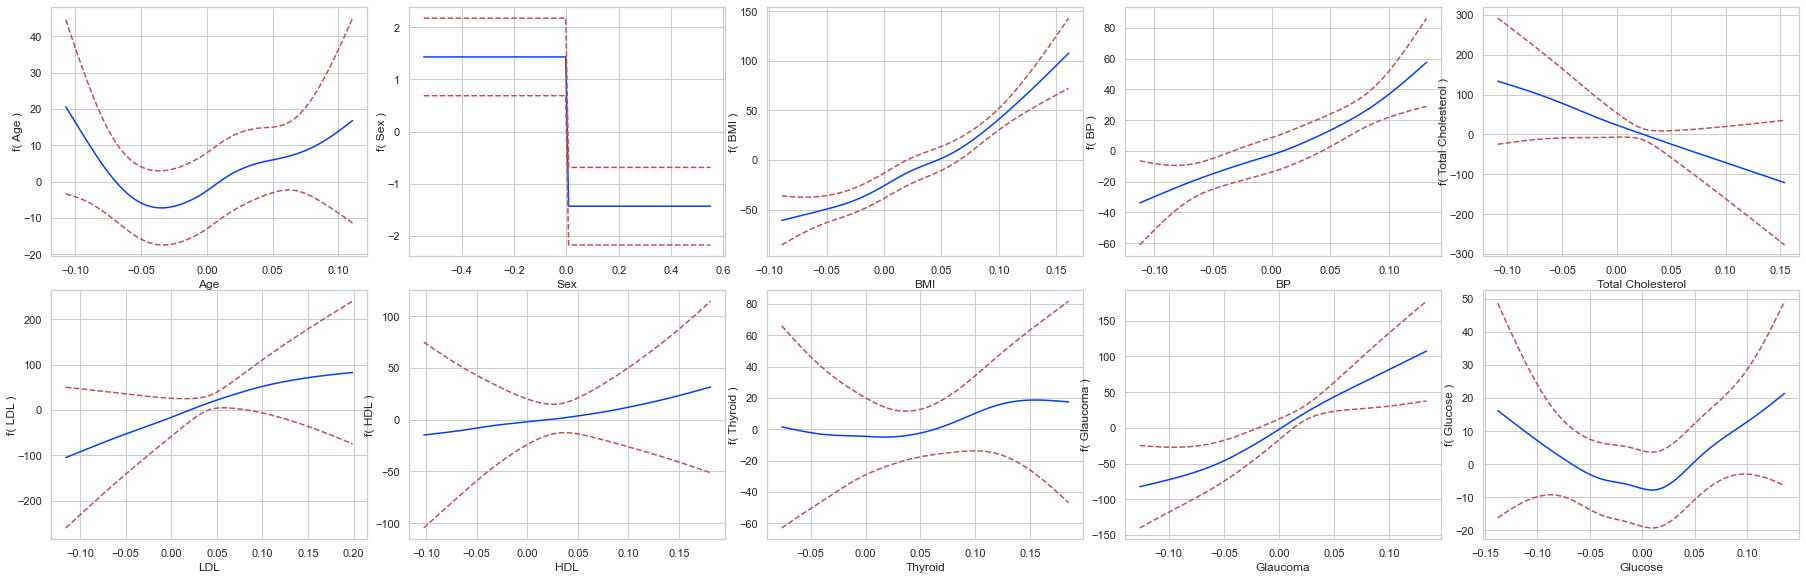

In [6]:
# Wygenerowanie funkcji reakcji:
print(feature_names)

# Mapowanie pozycji każdegi wykresu (wiersz, kolumna)
grid_locs1 = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
              (1, 0), (1, 1), (1, 2), (1, 3), (1, 4)]

# Tworzenie płótna i osi
fig, ax = plt.subplots(2, 5, figsize=(25, 8))

fig.tight_layout(pad=1)
# Wypełnienie osi
for i, feature in enumerate(feature_names):
    gl = grid_locs1[i]
    ax1 =  ax[gl[0], gl[1]]
    XX = gam.generate_X_grid(term=i)
    ax1.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax1.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax1.set_xlabel(f'{feature}')
    ax1.set_ylabel(f'f( {feature} )', labelpad=0)